# **<span style="color: Purple;"> 6 Hourly ERA-5 Reanalysis Horizontal Map</span>**
## **<span style="color: orange;">Created by: John Farash - Advised by: Kevin Tyle:</span>**
***


### **This notebook displays ERA-5 Renanalysis of different variables at various pressure levels for a maximum of 1 week**

#### **Documentation of Panel interactivity (https://panel.holoviz.org)**
***

### **Import everything needed and activate panel for interactivity**

In [88]:
import xarray as xr
import pandas as pd
import numpy as np
from datetime import datetime as dt
from metpy.units import units
import metpy.calc as mpcalc
from scipy import ndimage  
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import panel as pn
from PIL import Image
import io
import warnings
pn.extension()

## **Date Input**
### **Input a start and end date using the cells below**
***

In [89]:
start1 = pn.widgets.DatePicker(name='Start Date')
pn.Column(start1, height=400)


Column(height=400)
    [0] DatePicker(name='Start Date')

In [90]:
end1 = pn.widgets.DatePicker(name='End Date')
pn.Column(end1, height=400)


Column(height=400)
    [0] DatePicker(name='End Date')

## **Time Input**
### **Input a start and end time**
***

In [91]:
starttime1 = pn.widgets.Select(name='Start Time UTC', options=['00:00', '06:00','12:00','18:00'])
endtime1 = pn.widgets.Select(name='End Time UTC', options=['00:00', '06:00','12:00','18:00'])

layout = pn.Column(starttime1, endtime1)
layout.servable()

Column
    [0] Select(name='Start Time UTC', options=['00:00', '06:00', ...], value='00:00')
    [1] Select(name='End Time UTC', options=['00:00', '06:00', ...], value='00:00')

## **Run this cell to check for a 1 week time span and that the date and time inputs are sucsessful**
***

In [92]:
start_time_str = starttime1.value
end_time_str = endtime1.value

time_start = dt.strptime(start_time_str, "%H:%M").time()
time_end = dt.strptime(end_time_str, "%H:%M").time()

start_datetime = dt.combine(start1.value, time_start)
end_datetime = dt.combine(end1.value, time_end)


if end_datetime < start_datetime:
    raise ValueError("**Warning:** End date and time cannot be before start date and time!")

datelist = pd.date_range(start_datetime, end_datetime,freq="6h")
if len(datelist) > 28:
    raise ValueError("WARNING!: The date range exceeds one week, please go back to the date inputs and make the time range less than a week. ")
else:
    print("Sucsess!")

dateList=datelist

Sucsess!


## **Open the ERA5 data store**
***

In [93]:
reanalysis = xr.open_zarr(
    'gs://gcp-public-data-arco-era5/ar/1959-2022-full_37-1h-0p25deg-chunk-1.zarr-v2', 
    consolidated=True
)

## **Input viewing area**
***

In [94]:
# Text input widgets for coordinates
lonWtxt = pn.widgets.TextInput(name='Enter Western Longitude Coordinate', placeholder='-180 to 180')
lonEtxt = pn.widgets.TextInput(name='Enter Eastern Longitude Coordinate', placeholder='-180 to 180')
latNtxt = pn.widgets.TextInput(name='Enter Northern Latitude Coordinate', placeholder='-90 to 90')
latStxt = pn.widgets.TextInput(name='Enter Southern Latitude Coordinate', placeholder='-90 to 90')

# Widget to display messages
output = pn.widgets.StaticText(value="", width=400)

def check_coords(event):
    # Clear the output text
    output.value = ""
    
    try:
        # Check Western Longitude
        if event.obj == lonWtxt:
            if lonWtxt.value == '':
                return 
            value = float(lonWtxt.value)
            if value < -180 or value > 180:
                raise ValueError("WARNING!: West Longitude input out of range.")
            else:
                output.value = "Success! Input Longitude West"
        
        # Check Eastern Longitude
        elif event.obj == lonEtxt:
            if lonEtxt.value == '':
                return  
            value = float(lonEtxt.value)
            if value < -180 or value > 180:
                raise ValueError("WARNING!: East Longitude input out of range.")
            else:
                output.value = "Success! Input Longitude East"

            # Check if West Longitude is greater than East Longitude
            if lonWtxt.value != '' and float(lonEtxt.value) <= float(lonWtxt.value):
                raise ValueError("WARNING!: Eastern Longitude must be greater than Western Longitude!")

        # Check Northern Latitude
        elif event.obj == latNtxt:
            if latNtxt.value == '':
                return  
            value = float(latNtxt.value)
            if value < -90 or value > 90:
                raise ValueError("WARNING!: North Latitude input out of range.")
            else:
                output.value = "Success! Input Latitude North"
        
        # Check Southern Latitude
        elif event.obj == latStxt:
            if latStxt.value == '':
                return  
            value = float(latStxt.value)
            if value < -90 or value > 90:
                raise ValueError("WARNING!: South Latitude input out of range.")
            else:
                output.value = "Success! Input Latitude South"
            
            if latNtxt.value != '' and float(latNtxt.value) <= float(latStxt.value):
                raise ValueError("WARNING!: Northern Latitude must be greater than Southern Latitude!")

    except ValueError as e:
        output.value = f"Error occurred: {e}"
    except Exception as e:
        output.value = f"An unexpected error occurred: {e}"

# Watch for changes in the text inputs
lonWtxt.param.watch(check_coords, 'value')
lonEtxt.param.watch(check_coords, 'value')
latNtxt.param.watch(check_coords, 'value')
latStxt.param.watch(check_coords, 'value')

# Create a layout and make it servable
layout = pn.Column(lonWtxt, lonEtxt, latNtxt, latStxt, output)
layout.servable()


Column
    [0] TextInput(name='Enter Western L..., placeholder='-180 to 180')
    [1] TextInput(name='Enter Eastern L..., placeholder='-180 to 180')
    [2] TextInput(name='Enter Northern L..., placeholder='-90 to 90')
    [3] TextInput(name='Enter Southern L..., placeholder='-90 to 90')
    [4] StaticText(width=400)

### **Run this cell to set variables for plotting based off area of interest input above**
***

In [95]:
lonW = float(lonWtxt.value) + 360
lonE = float(lonEtxt.value) + 360
latS = float(latStxt.value)
latN = float(latNtxt.value)
inc=.25
cLat, cLon = (latS + latN)/2, (lonW + lonE)/2
latRange = np.arange(latN,latS-inc,-inc) # expand the data range a bit beyond the plot range
lonRange = np.arange(lonW,lonE+inc,+inc) # Need to match longitude values to those of the coordinate variable
constrainLat, constrainLon = (0.6, 7)
proj_map = ccrs.LambertConformal(central_longitude=cLon, central_latitude=cLat)
proj_data = ccrs.PlateCarree() # Our data is lat-lon; thus its native projection is Plate Carree.
res = '50m'

### **Run this cell to check domain**
***

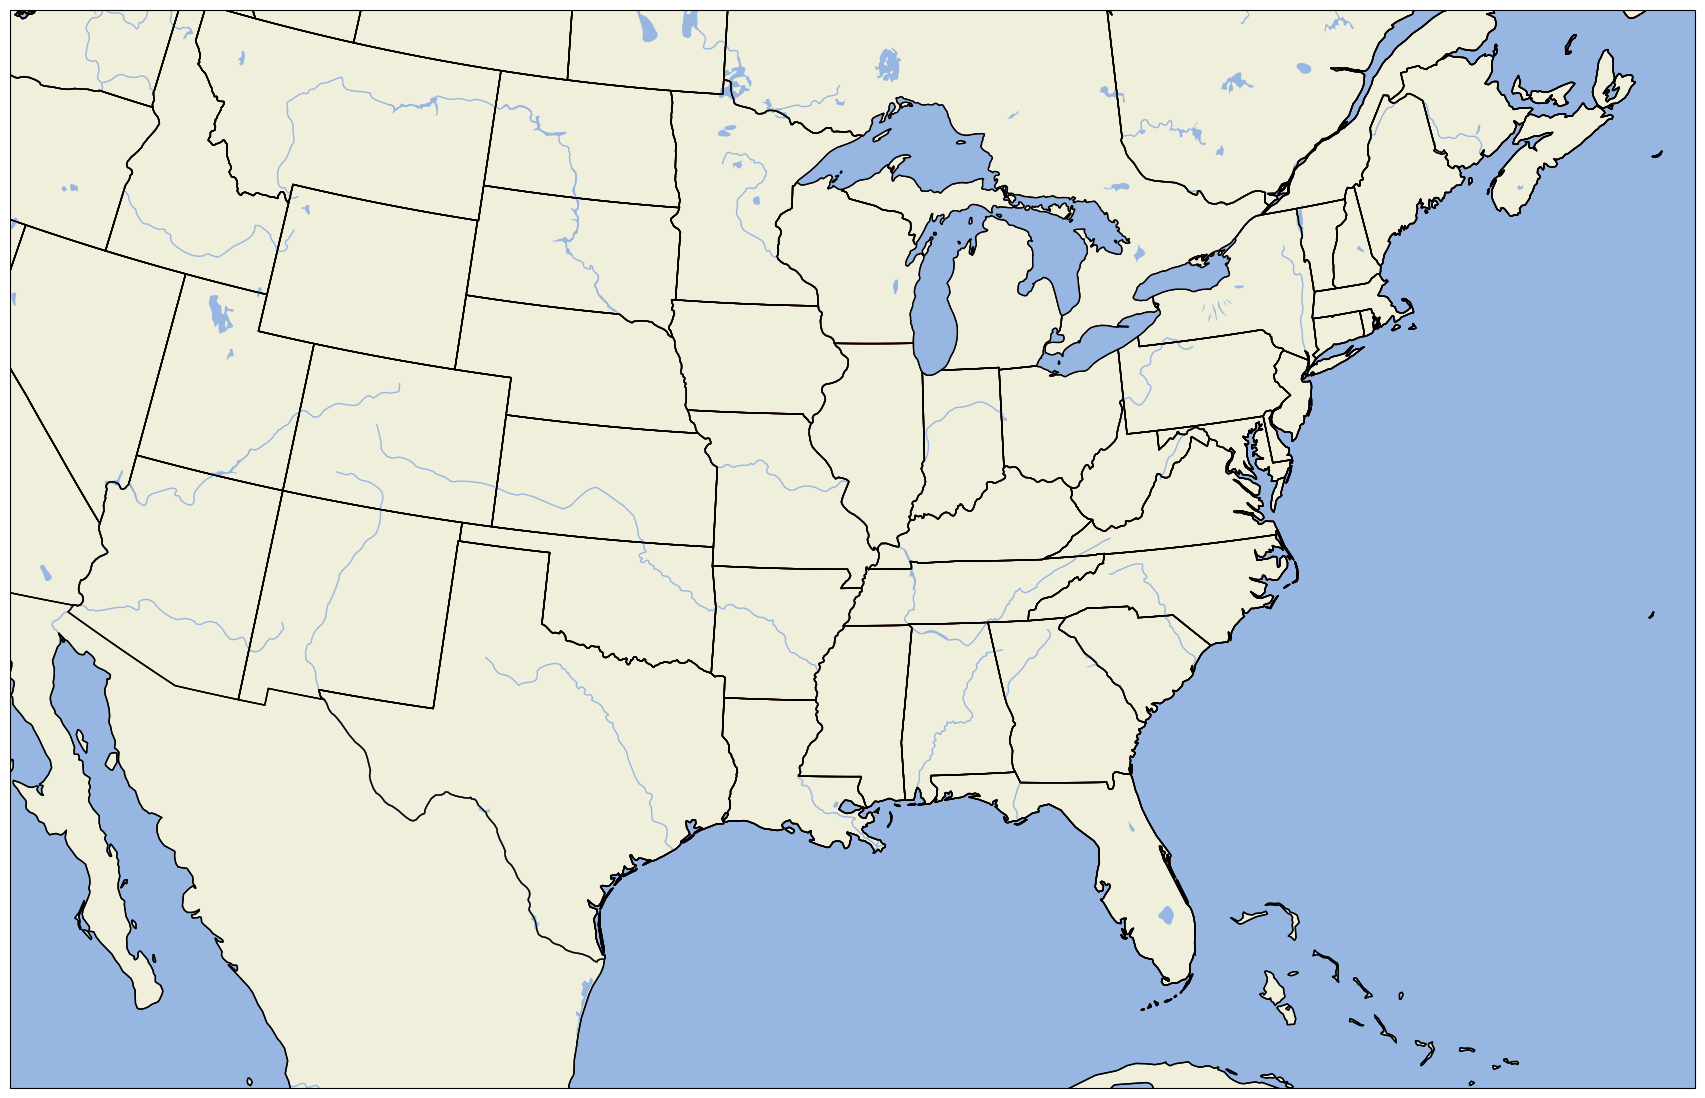

In [96]:
fig = plt.figure(figsize=(22,14)) # Increase size to adjust for the constrained lats/lons
ax = plt.subplot(1,1,1,projection=proj_map)
ax.set_extent ([lonW+constrainLon,lonE-constrainLon,latS+constrainLat,latN-constrainLat])
ax.add_feature(cfeature.COASTLINE.with_scale(res))
ax.add_feature(cfeature.STATES.with_scale(res),edgecolor='brown')
ax.add_feature (cfeature.STATES.with_scale(res))
ax.add_feature (cfeature.RIVERS.with_scale(res))
ax.add_feature (cfeature.LAND.with_scale(res))
ax.add_feature (cfeature.COASTLINE.with_scale(res))
ax.add_feature (cfeature.LAKES.with_scale(res))
ax.add_feature (cfeature.STATES.with_scale(res))
ax.add_feature(cfeature.OCEAN)
    

## **Input variable and pressure level of interest**
### **MSLP and 1000-500mb thickness do not require a pressure level input, it can be ignored**
***

In [97]:
# Create the variable selection dropdown
variable_selection = pn.widgets.Select(name='Choose a Variable', options=[
    'MSLP', 'Vorticity', 'Geopotential Height','1000-500mb Thickness', 'Winds',
    'Dewpoint', 'Relative Humidity','Temperature',
    'Temperature Advection', 'Frontogenesis', 'Omega','Q-Vector'
])

# Create the pressure level selection dropdown
plevel_selection = pn.widgets.Select(name='Choose a Pressure Level (mb)', options=['950', '850', '700', '500', '300', '250'])

# Create output panes for displaying selections
output1 = pn.pane.Markdown("")
output2 = pn.pane.Markdown("")

# Function to respond to variable dropdown selection
def variable_dropdown_callback(event):
    # Clear previous output
    output1.object = ""
    
    # Update output with the selected variable
    output1.object = f"You selected variable: **{event.new}**"

# Function to respond to pressure level dropdown selection
def plevel_dropdown_callback(event):
    # Clear previous output
    output2.object = ""
    
    # Update output with the selected pressure level
    output2.object = f"You selected pressure level: **{event.new} mb**"

# Watch for changes in the dropdown selections
variable_selection.param.watch(variable_dropdown_callback, 'value')
plevel_selection.param.watch(plevel_dropdown_callback, 'value')

# Display the dropdowns and their outputs
pn.Column(variable_selection, output1, plevel_selection, output2).servable()

Column
    [0] Select(name='Choose a Variable', options=['MSLP', 'Vorticity', ...], value='MSLP')
    [1] Markdown(str)
    [2] Select(name='Choose a Pressure L..., options=['950', '850', ...], value='950')
    [3] Markdown(str)

## **Run this cell to generate the plots based off chosen parameters**
### **Warning! Based off time and variable chosen the plot could take several minutes to generate**
***

Processing 2021-12-02 00:00:00


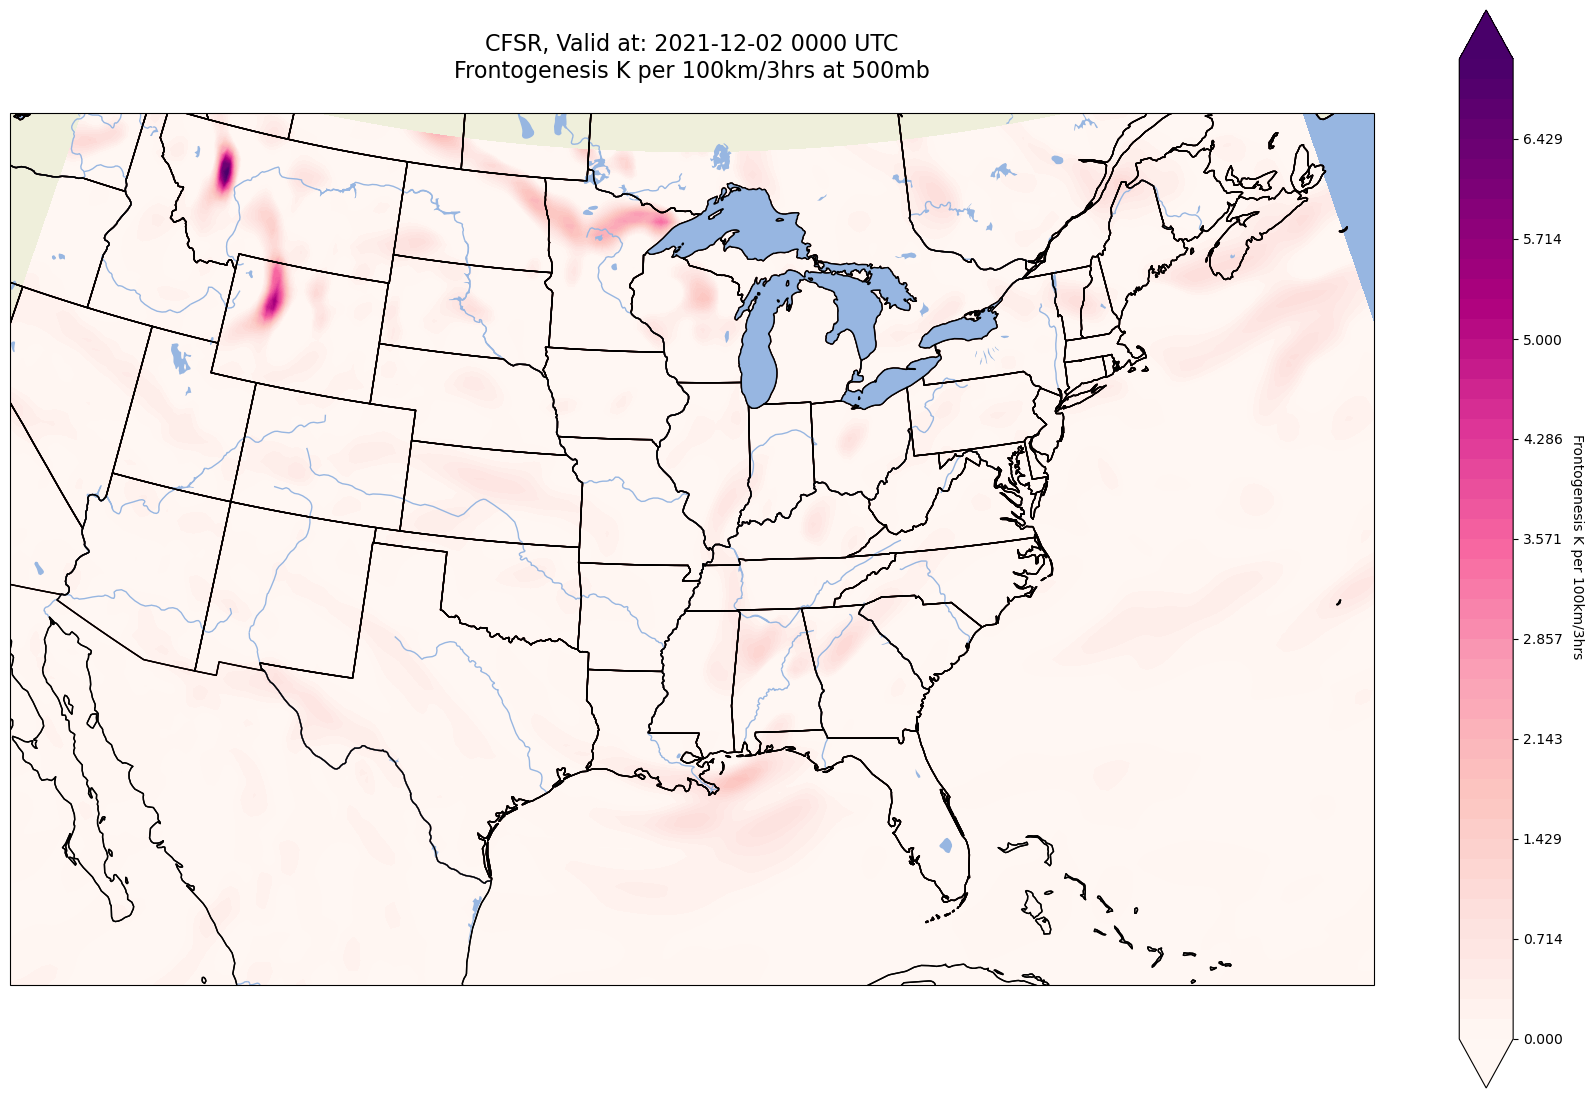

In [127]:
# Assuming plevel_selection and variable_selection are already defined Select widgets
plevel = int(plevel_selection.value)
variable = variable_selection.value

# Initialize var to None or a default value
var = None


############################################################################################################################################
# Set the variable based on the user's selection
if variable == 'Geopotential Height':
    var = 'geopotential'
    data_geo = reanalysis[var].sel(time=dateList, level=plevel, latitude=latRange, longitude=lonRange)
    data = (mpcalc.geopotential_to_height(data_geo)).metpy.convert_units('dam').compute()

    lats = data.latitude
    lons = data.longitude
    
    
    contour_int = 6 
    min_cont, max_cont = int(data.min().values), int(data.max().values)
    Contours = np.linspace(min_cont, max_cont, num=50)

    cmap='jet'
    bounds = np.arange(min_cont, max_cont, 10)

# ******************Graphing*********** 
    
    for time in dateList:
        print("Processing", time)
    
        # Create the time strings, for the figure title as well as for the file name.
        timeStr = dt.strftime(time,format="%Y-%m-%d %H%M UTC")
        timeStrFile = dt.strftime(time,format="%Y%m%d%H")
        levstr = f'{plevel} mb'
    
        tl1 = str('ERA5, Valid at: '+ timeStr)
        tl2 = "Geopotential Height at " + levstr
    
        title_line = (tl1 + '\n' + tl2 + '\n')
    
        fig = plt.figure(figsize=(22,14)) # Increase size to adjust for the constrained lats/lons
        ax = plt.subplot(1,1,1,projection=proj_map)
        ax.set_extent ([lonW+constrainLon,lonE-constrainLon,latS+constrainLat,latN-constrainLat])
        ax.add_feature(cfeature.COASTLINE.with_scale(res))
        ax.add_feature(cfeature.STATES.with_scale(res),edgecolor='brown')
        ax.add_feature (cfeature.STATES.with_scale(res))
        ax.add_feature (cfeature.RIVERS.with_scale(res))
        ax.add_feature (cfeature.LAND.with_scale(res))
        ax.add_feature (cfeature.COASTLINE.with_scale(res))
        ax.add_feature (cfeature.LAKES.with_scale(res))
        ax.add_feature (cfeature.STATES.with_scale(res))
        ax.add_feature(cfeature.OCEAN)
    
 
        # Contour lines 
        c = ax.contourf(lons, lats, data.sel(time=time), levels=Contours, cmap=cmap, transform=proj_data)
        cbar= plt.colorbar(c, ax=ax, ticks=bounds)
        cbar.set_label('Geopotential Height dam', rotation=270, labelpad=15)
        title = plt.title(title_line,fontsize=16)
        plt.show()


############################################################################################################################################
elif variable == 'MSLP':
    var = 'mean_sea_level_pressure'
    data = (reanalysis[var].sel(time=dateList, latitude=latRange, longitude=lonRange)).metpy.convert_units('hPa').compute()

    lats = data.latitude
    lons = data.longitude

    contour_int = 4 
    min_cont, max_cont = int(data.min().values), int(data.max().values)
    Contours = (np.arange(min_cont, max_cont,contour_int)).astype(int)

# ******************Graphing*********** 
    for time in dateList:
        print("Processing", time)
    
        # Create the time strings, for the figure title as well as for the file name.
        timeStr = dt.strftime(time,format="%Y-%m-%d %H%M UTC")
        timeStrFile = dt.strftime(time,format="%Y%m%d%H")
    
        tl1 = str('ERA5, Valid at: '+ timeStr)
        tl2 = "MSLP (hPa)"
        
        title_line = (tl1 + '\n' + tl2 + '\n')
    
        fig = plt.figure(figsize=(22,14)) # Increase size to adjust for the constrained lats/lons
        ax = plt.subplot(1,1,1,projection=proj_map)
        ax.set_extent ([lonW+constrainLon,lonE-constrainLon,latS+constrainLat,latN-constrainLat])
        ax.add_feature(cfeature.COASTLINE.with_scale(res))
        ax.add_feature(cfeature.STATES.with_scale(res),edgecolor='brown')
        ax.add_feature (cfeature.STATES.with_scale(res))
        ax.add_feature (cfeature.RIVERS.with_scale(res))
        ax.add_feature (cfeature.LAND.with_scale(res))
        ax.add_feature (cfeature.COASTLINE.with_scale(res))
        ax.add_feature (cfeature.LAKES.with_scale(res))
        ax.add_feature (cfeature.STATES.with_scale(res))
        ax.add_feature(cfeature.OCEAN)
    
 
        # Contour lines 
        cSLP = ax.contour(lons, lats, data.sel(time=time), levels=Contours, colors='black', linewidths=3, transform=proj_data)
        ax.clabel(cSLP, inline=1, fontsize=12, fmt='%.0f')
        title = plt.title(title_line,fontsize=16)


    
############################################################################################################################################
elif variable == 'Winds':
    var1 = 'u_component_of_wind'
    var2 = 'v_component_of_wind'
    data_wind = {
        'U': (reanalysis[var1].sel(time=dateList, level=plevel, latitude=latRange, longitude=lonRange)).metpy.convert_units('kts'),
        'V': (reanalysis[var2].sel(time=dateList, level=plevel, latitude=latRange, longitude=lonRange)).metpy.convert_units('kts')
    }
    data = (mpcalc.wind_speed(data_wind['U'], data_wind['V'])).compute()

    lats = data.latitude
    lons = data.longitude
    

    if plevel in [250,300]:
        contour_int = 10 
        min_cont, max_cont = (50,220)
        Contours = np.linspace(min_cont, max_cont, num=50)
        ticks = np.arange(50,240,20)

    elif plevel in [500,700]:
        contour_int = 10 
        min_cont, max_cont = (30,200)
        Contours = np.linspace(min_cont, max_cont, num=50)
        ticks = np.arange(30,220,20)

    elif plevel in [850,950]:
        contour_int = 10 
        min_cont, max_cont = (30,150)
        Contours = np.linspace(min_cont, max_cont, num=50)
        ticks = np.arange(30,170,20)
    
    
# ******************Graphing***********
    
    for time in dateList:
        print("Processing", time)
    
        # Create the time strings, for the figure title as well as for the file name.
        timeStr = dt.strftime(time,format="%Y-%m-%d %H%M UTC")
        timeStrFile = dt.strftime(time,format="%Y%m%d%H")
        levstr = (f'str{plevel}+"mb"')
    
        tl1 = str('ERA5, Valid at: '+ timeStr)
        tl2 = ("Winds (kts) at " + levstr)
    
        title_line = (tl1 + '\n' + tl2 + '\n')
    
        fig = plt.figure(figsize=(22,14)) # Increase size to adjust for the constrained lats/lons
        ax = plt.subplot(1,1,1,projection=proj_map)
        ax.set_extent ([lonW+constrainLon,lonE-constrainLon,latS+constrainLat,latN-constrainLat])
        ax.add_feature(cfeature.COASTLINE.with_scale(res))
        ax.add_feature(cfeature.STATES.with_scale(res),edgecolor='brown')
        ax.add_feature (cfeature.STATES.with_scale(res))
        ax.add_feature (cfeature.RIVERS.with_scale(res))
        ax.add_feature (cfeature.LAND.with_scale(res))
        ax.add_feature (cfeature.COASTLINE.with_scale(res))
        ax.add_feature (cfeature.LAKES.with_scale(res))
        ax.add_feature (cfeature.STATES.with_scale(res))
        ax.add_feature(cfeature.OCEAN)
    
 
        # Contour lines 
        
        contourf=ax.contourf(lons,lats,data.sel(time=time),levels=Contours,cmap='cool',transform=proj_data)
        cbar = plt.colorbar(contourf, ax=ax, ticks=ticks)
        cbar.set_label('Wind Speed kts',rotation=270, labelpad=15)
    
        # Wind barbs
        skip = 6
        ax.barbs(lons[::skip],lats[::skip],data_wind['U'].sel(time=time)[::skip,::skip].values, data_wind['V'].sel(time=time)[::skip,::skip].values, color='black',zorder=2,transform=proj_data,length=6)

        title = plt.title(title_line,fontsize=16)



############################################################################################################################################
elif variable == 'Vorticity':
    var1 = 'u_component_of_wind'
    var2 = 'v_component_of_wind'
    data_wind = {
        'U': (reanalysis[var1].sel(time=dateList, level=plevel, latitude=latRange, longitude=lonRange)),
        'V': (reanalysis[var2].sel(time=dateList, level=plevel, latitude=latRange, longitude=lonRange))
    }
    data = ((mpcalc.vorticity(data_wind['U'], data_wind['V']))*1e5).compute()

    contour_int = 5 
    min_cont, max_cont = 5 , int(data.max().values)
    Contours = np.linspace(min_cont, max_cont, num=50)

    cmap='copper_r'
    bounds = np.arange(5, 50, 10)
    ticks = bounds


    for time in dateList:
        print("Processing", time)
    
        # Create the time strings, for the figure title as well as for the file name.
        timeStr = dt.strftime(time,format="%Y-%m-%d %H%M UTC")
        timeStrFile = dt.strftime(time,format="%Y%m%d%H")
        levstr=f'{plevel}'
    
        tl1 = str('ERA5, Valid at: '+ timeStr)
        tl2 = ("Vorticity 1/s x10^5 at " + levstr + "mb")
    
        title_line = (tl1 + '\n' + tl2 + '\n')
    
        fig = plt.figure(figsize=(22,14)) # Increase size to adjust for the constrained lats/lons
        ax = plt.subplot(1,1,1,projection=proj_map)
        ax.set_extent ([lonW+constrainLon,lonE-constrainLon,latS+constrainLat,latN-constrainLat])
        ax.add_feature(cfeature.COASTLINE.with_scale(res))
        ax.add_feature(cfeature.STATES.with_scale(res),edgecolor='brown')
        ax.add_feature (cfeature.STATES.with_scale(res))
        ax.add_feature (cfeature.RIVERS.with_scale(res))
        ax.add_feature (cfeature.LAND.with_scale(res))
        ax.add_feature (cfeature.COASTLINE.with_scale(res))
        ax.add_feature (cfeature.LAKES.with_scale(res))
        ax.add_feature (cfeature.STATES.with_scale(res))
        ax.add_feature(cfeature.OCEAN)
    
 
    # Contour lines 

        contourf=ax.contourf(lons,lats,data.sel(time=time),levels=Contours,cmap=cmap,transform=proj_data)
        cbar = plt.colorbar(contourf, ax=ax, ticks=ticks)
        cbar.set_label('Vorticity 1/s *10^5', rotation=270, labelpad=15)
    
        title = plt.title(title_line,fontsize=16)





############################################################################################################################################
elif variable == 'Dewpoint':
    var = 'specific_humidity'
    data_dew = reanalysis[var].sel(time=dateList, level=plevel, latitude=latRange, longitude=lonRange)
    data = (mpcalc.dewpoint_from_specific_humidity(plevel*units.hPa,data_dew)).metpy.convert_units('degF').compute()

    lats = data.latitude
    lons = data.longitude

    contour_int = 10 
    min_cont,max_cont = -140,140
    Contours = np.linspace(min_cont,max_cont,50)

    cmap='terrain_r'
    bounds = np.arange(-140, 140, 10)
    ticks = bounds

    for time in dateList:
        print("Processing", time)
    
        # Create the time strings, for the figure title as well as for the file name.
        timeStr = dt.strftime(time,format="%Y-%m-%d %H%M UTC")
        timeStrFile = dt.strftime(time,format="%Y%m%d%H")
        levstr=f'{plevel}'
    
        tl1 = str('ERA5, Valid at: '+ timeStr)
        tl2 = ("Dewpoint Temperature °F at " + levstr + "mb")
    
        title_line = (tl1 + '\n' + tl2 + '\n')
    
        fig = plt.figure(figsize=(22,14)) # Increase size to adjust for the constrained lats/lons
        ax = plt.subplot(1,1,1,projection=proj_map)
        ax.set_extent ([lonW+constrainLon,lonE-constrainLon,latS+constrainLat,latN-constrainLat])
        ax.add_feature(cfeature.COASTLINE.with_scale(res))
        ax.add_feature(cfeature.STATES.with_scale(res),edgecolor='brown')
        ax.add_feature (cfeature.STATES.with_scale(res))
        ax.add_feature (cfeature.RIVERS.with_scale(res))
        ax.add_feature (cfeature.LAND.with_scale(res))
        ax.add_feature (cfeature.COASTLINE.with_scale(res))
        ax.add_feature (cfeature.LAKES.with_scale(res))
        ax.add_feature (cfeature.STATES.with_scale(res))
        ax.add_feature(cfeature.OCEAN)
    
 
        # Contour lines 

        contourf=ax.contourf(lons,lats,data.sel(time=time),levels=Contours,cmap=cmap,transform=proj_data,extend='both')
    
        cbar=plt.colorbar(contourf, ax=ax, ticks=ticks)
        cbar.set_label('Dewpoint °F', rotation=270, labelpad=15)
    
        title = plt.title(title_line,fontsize=16)



############################################################################################################################################
elif variable == 'Temperature':
    var = 'temperature'
    data = reanalysis[var].sel(time=dateList, level=plevel, latitude=latRange, longitude=lonRange).metpy.convert_units('degF').compute()

    lats = data.latitude
    lons = data.longitude
    
    contour_int = 10 
    min_cont,max_cont = -140,140
    Contours = np.linspace(min_cont,max_cont,50)

    cmap='jet'
    bounds = np.arange(-140, 140, 10)
    ticks = bounds

    for time in dateList:
        print("Processing", time)
    
        # Create the time strings, for the figure title as well as for the file name.
        timeStr = dt.strftime(time,format="%Y-%m-%d %H%M UTC")
        timeStrFile = dt.strftime(time,format="%Y%m%d%H")
        levstr=f'{plevel}'
    
        tl1 = str('ERA5, Valid at: '+ timeStr)
        tl2 = ("Temperature °F at " + levstr + "mb")
    
        title_line = (tl1 + '\n' + tl2 + '\n')
    
        fig = plt.figure(figsize=(22,14)) # Increase size to adjust for the constrained lats/lons
        ax = plt.subplot(1,1,1,projection=proj_map)
        ax.set_extent ([lonW+constrainLon,lonE-constrainLon,latS+constrainLat,latN-constrainLat])
        ax.add_feature(cfeature.COASTLINE.with_scale(res))
        ax.add_feature(cfeature.STATES.with_scale(res),edgecolor='brown')
        ax.add_feature (cfeature.STATES.with_scale(res))
        ax.add_feature (cfeature.RIVERS.with_scale(res))
        ax.add_feature (cfeature.LAND.with_scale(res))
        ax.add_feature (cfeature.COASTLINE.with_scale(res))
        ax.add_feature (cfeature.LAKES.with_scale(res))
        ax.add_feature (cfeature.STATES.with_scale(res))
        ax.add_feature(cfeature.OCEAN)
    
 
        # Contour lines 
    
        contourf=ax.contourf(lons,lats,data.sel(time=time),levels=Contours,cmap=cmap,transform=proj_data)
        cbar = plt.colorbar(contourf, ax=ax, ticks=ticks)
        cbar.set_label('Temperature °F',rotation=270, labelpad=15)

    
        title = plt.title(title_line,fontsize=16)
    


############################################################################################################################################
elif variable == 'Temperature Advection':
    var1 = 'temperature'
    var2 = 'u_component_of_wind'
    var3 = 'v_component_of_wind'
    data_tadv = {
        'T': (reanalysis[var1].sel(time=dateList, level=plevel, latitude=latRange, longitude=lonRange)),
        'U': (reanalysis[var2].sel(time=dateList, level=plevel, latitude=latRange, longitude=lonRange)),
        'V': (reanalysis[var3].sel(time=dateList, level=plevel, latitude=latRange, longitude=lonRange))
    }
    data_tadv = mpcalc.advection(data_tadv['T'],data_tadv['U'], data_tadv['V'])
    
    kelvin_to_fahrenheit = 9 / 5  # Conversion factor for K to °F
    seconds_to_hours = 3600       # Conversion factor for seconds to hours

    temperature_adv_f_per_s = data_tadv * kelvin_to_fahrenheit

    #Convert from °F/s to °F/hr
    temperature_adv_f_per_hr = (temperature_adv_f_per_s * seconds_to_hours)*10
    data=temperature_adv_f_per_hr.compute()
    data = mpcalc.smooth_gaussian(data,5)

    lats = data.latitude
    lons = data.longitude
    

    contour_int = 10
    min_cont, max_cont = (-100,100)


    neg_contours = np.linspace(min_cont, -10, 50)  
    pos_contours = np.linspace(10, max_cont , 50)
    
    Contours = np.concatenate([neg_contours, pos_contours])
    cmap = 'RdBu_r'
    bounds = np.arange(min_cont, max_cont, 10)
    ticks = bounds

    for time in dateList:
        print("Processing", time)
    
        # Create the time strings, for the figure title as well as for the file name.
        timeStr = dt.strftime(time,format="%Y-%m-%d %H%M UTC")
        timeStrFile = dt.strftime(time,format="%Y%m%d%H")
        levstr=f'{plevel}'
    
        tl1 = str('ERA5, Valid at: '+ timeStr)
        tl2 = ("Temperature Advection °F/hr " + levstr + "mb")
    
        title_line = (tl1 + '\n' + tl2 + '\n')
    
        fig = plt.figure(figsize=(22,14)) # Increase size to adjust for the constrained lats/lons
        ax = plt.subplot(1,1,1,projection=proj_map)
        ax.set_extent ([lonW+constrainLon,lonE-constrainLon,latS+constrainLat,latN-constrainLat])
        ax.add_feature(cfeature.COASTLINE.with_scale(res))
        ax.add_feature(cfeature.STATES.with_scale(res),edgecolor='brown')
        ax.add_feature (cfeature.STATES.with_scale(res))
        ax.add_feature (cfeature.RIVERS.with_scale(res))
        #ax.add_feature (cfeature.LAND.with_scale(res))
        ax.add_feature (cfeature.COASTLINE.with_scale(res))
        ax.add_feature (cfeature.LAKES.with_scale(res))
        ax.add_feature (cfeature.STATES.with_scale(res))
        #ax.add_feature(cfeature.OCEAN)
    
    
        contourf=ax.contourf(lons,lats,data.sel(time=time),levels=Contours,cmap=cmap,transform=proj_data,extend='both')
        cbar = plt.colorbar(contourf, ax=ax, ticks=ticks)
        cbar.set_label('Temperature Advection °F/hr ', rotation=270, labelpad=15)
    
        title = plt.title(title_line,fontsize=16)
############################################################################################################################################
elif variable == 'Frontogenesis':
    var1 = 'temperature'
    var2 = 'u_component_of_wind'
    var3 = 'v_component_of_wind'
    data_fronto = {
        'T': (reanalysis[var1].sel(time=dateList, level=plevel, latitude=latRange, longitude=lonRange)),
        'U': (reanalysis[var2].sel(time=dateList, level=plevel, latitude=latRange, longitude=lonRange)),
        'V': (reanalysis[var3].sel(time=dateList, level=plevel, latitude=latRange, longitude=lonRange))
    }
    U = data_fronto['U'].compute()
    V = data_fronto['V'].compute()
    pottemp = mpcalc.potential_temperature(plevel*units.hPa,data_fronto['T']).compute()
    fgen = mpcalc.frontogenesis(pottemp,data_fronto['U'],data_fronto['V'])
    fgen = mpcalc.smooth_gaussian(fgen,5)
    
    convert_to_per_100km_3h = 1000*100*3600*3
    scale = 1e0
    data = (fgen * convert_to_per_100km_3h).compute()

    lats = data.latitude
    lons = data.longitude

    contour_int = 1
    min_cont, max_cont = (0,int(data.max().values))
    
    Contours = np.linspace(min_cont,max_cont,50)
    cmap = 'RdPu'
    bounds = np.arange(min_cont, max_cont, 10)
    ticks = bounds

    for time in dateList:
        print("Processing", time)
    
        # Create the time strings, for the figure title as well as for the file name.
        timeStr = dt.strftime(time,format="%Y-%m-%d %H%M UTC")
        timeStrFile = dt.strftime(time,format="%Y%m%d%H")
        levstr=f'{plevel}'
        
        tl1 = str('CFSR, Valid at: '+ timeStr)
        tl2 = ("Frontogenesis K per 100km/3hrs at " + levstr + "mb" )
    
        title_line = (tl1 + '\n' + tl2 + '\n')
    
        fig = plt.figure(figsize=(22,14)) # Increase size to adjust for the constrained lats/lons
        ax = plt.subplot(1,1,1,projection=proj_map)
        ax.set_extent ([lonW+constrainLon,lonE-constrainLon,latS+constrainLat,latN-constrainLat])
        ax.add_feature(cfeature.COASTLINE.with_scale(res))
        ax.add_feature(cfeature.STATES.with_scale(res),edgecolor='brown')
        ax.add_feature (cfeature.STATES.with_scale(res))
        ax.add_feature (cfeature.RIVERS.with_scale(res))
        #ax.add_feature (cfeature.LAND.with_scale(res))
        ax.add_feature (cfeature.COASTLINE.with_scale(res))
        ax.add_feature (cfeature.LAKES.with_scale(res))
        ax.add_feature (cfeature.STATES.with_scale(res))
        #ax.add_feature(cfeature.OCEAN)

        contourf=ax.contourf(lons,lats,data.sel(time=time)*scale,levels=Contours,cmap=cmap,transform=proj_data,extend='both')
        cbar = plt.colorbar(contourf, ax=ax)
        cbar.set_label('Frontogenesis K per 100km/3hrs ', rotation=270, labelpad=15)
    
        title = plt.title(title_line,fontsize=16)
    
############################################################################################################################################
elif variable == 'Relative Humidity':
    var1 = 'specific_humidity'
    var2 = 'temperature'
    
    data_rh = { 
        'Q': (reanalysis[var1].sel(time=dateList, level=plevel, latitude=latRange, longitude=lonRange)),
        'T': (reanalysis[var2].sel(time=dateList, level=plevel, latitude=latRange, longitude=lonRange))
    }
    data = ((mpcalc.relative_humidity_from_specific_humidity(plevel*units.hPa,data_rh['T'],data_rh['Q']))*100).compute()

    lats = data.latitude
    lons = data.longitude

    contour_int = 1
    min_cont, max_cont = (1,100)
    
    Contours = np.linspace(min_cont,max_cont,50)
    cmap = 'BrBG'
    bounds = np.arange(0, 110, 10)
    ticks = bounds

    for time in dateList:
        print("Processing", time)
    
        # Create the time strings, for the figure title as well as for the file name.
        timeStr = dt.strftime(time,format="%Y-%m-%d %H%M UTC")
        timeStrFile = dt.strftime(time,format="%Y%m%d%H")
        levstr=f'{plevel}'
    
        tl1 = str('ERA5, Valid at: '+ timeStr)
        tl2 = ("Relative Humidty % at " + levstr + "mb")
    
        title_line = (tl1 + '\n' + tl2 + '\n')
    
        fig = plt.figure(figsize=(22,14)) # Increase size to adjust for the constrained lats/lons
        ax = plt.subplot(1,1,1,projection=proj_map)
        ax.set_extent ([lonW+constrainLon,lonE-constrainLon,latS+constrainLat,latN-constrainLat])
        ax.add_feature(cfeature.COASTLINE.with_scale(res))
        ax.add_feature(cfeature.STATES.with_scale(res),edgecolor='brown')
        ax.add_feature (cfeature.STATES.with_scale(res))
        ax.add_feature (cfeature.RIVERS.with_scale(res))
        ax.add_feature (cfeature.LAND.with_scale(res))
        ax.add_feature (cfeature.COASTLINE.with_scale(res))
        ax.add_feature (cfeature.LAKES.with_scale(res))
        ax.add_feature (cfeature.STATES.with_scale(res))
        ax.add_feature(cfeature.OCEAN)
    
 
    # Contour lines 

        contourf=ax.contourf(lons,lats,data.sel(time=time),levels=Contours,cmap=cmap,transform=proj_data,extend='both')
        cbar = plt.colorbar(contourf, ax=ax, ticks=ticks)
        cbar.set_label('Relative Humidity %',rotation=270, labelpad=15)
    
    
        title = plt.title(title_line,fontsize=16)
############################################################################################################################################
elif variable == 'Omega':
    var = 'vertical_velocity'
    data = (reanalysis[var].sel(time=dateList, level=plevel, latitude=latRange, longitude=lonRange)).compute()

    lats = data.latitude
    lons = data.longitude
    
    contour_int = 10
    min_cont, max_cont = (-100,100)


    neg_contours = np.linspace(min_cont, -5, 50)  
    pos_contours = np.linspace(5, max_cont , 50)
    
    Contours = np.concatenate([neg_contours, pos_contours])
    cmap = 'PRGn'
    bounds = np.arange(-100, 100, 20)
    ticks = bounds

    for time in dateList:
        print("Processing", time)
    
        # Create the time strings, for the figure title as well as for the file name.
        timeStr = dt.strftime(time,format="%Y-%m-%d %H%M UTC")
        timeStrFile = dt.strftime(time,format="%Y%m%d%H")
        levstr=f'{plevel}'
    
        tl1 = str('ERA5, Valid at: '+ timeStr)
        tl2 = ("Omega pa/second at " + levstr + "mb")
    
        title_line = (tl1 + '\n' + tl2 + '\n')
    
        fig = plt.figure(figsize=(22,14)) # Increase size to adjust for the constrained lats/lons
        ax = plt.subplot(1,1,1,projection=proj_map)
        ax.set_extent ([lonW+constrainLon,lonE-constrainLon,latS+constrainLat,latN-constrainLat])
        ax.add_feature(cfeature.COASTLINE.with_scale(res))
        ax.add_feature(cfeature.STATES.with_scale(res),edgecolor='brown')
        ax.add_feature (cfeature.STATES.with_scale(res))
        ax.add_feature (cfeature.RIVERS.with_scale(res))
        #ax.add_feature (cfeature.LAND.with_scale(res))
        ax.add_feature (cfeature.COASTLINE.with_scale(res))
        ax.add_feature (cfeature.LAKES.with_scale(res))
        ax.add_feature (cfeature.STATES.with_scale(res))
        #ax.add_feature(cfeature.OCEAN)
        
 
        # Contour lines 
        
        contourf=ax.contourf(lons,lats,data.sel(time=time)*10,levels=Contours,cmap=cmap,transform=proj_data,extend='both')
        
    
        cbar = plt.colorbar(contourf, ax=ax)
        cbar.set_label('Omega pa/second ', rotation=270, labelpad=15)
        
        title = plt.title(title_line,fontsize=16)
    


############################################################################################################################################
elif variable == '1000-500mb Thickness':
    var = 'geopotential'
    kgeo = reanalysis[var].sel(time=dateList, level=1000, latitude=latRange, longitude=lonRange)
    fgeo = reanalysis[var].sel(time=dateList, level=500, latitude=latRange, longitude=lonRange)
    khght = (mpcalc.geopotential_to_height(kgeo)).metpy.convert_units('dam')
    fhght = (mpcalc.geopotential_to_height(fgeo)).metpy.convert_units('dam')

    data = (fhght - khght).compute()
    

    lats = data.latitude
    lons = data.longitude
    
    
    cint1 = np.arange(0,534,6)
    cint2 = np.array([540])
    cint3 = np.arange(546,1000,6)

# ******************Graphing*********** 
    for time in dateList:
        
        timeStr = dt.strftime(time,format="%Y-%m-%d %H%M UTC")
        timeStrFile = dt.strftime(time,format="%Y%m%d%H")
        levstr = (f'str{plevel}+"mb"')
    
        tl1 = str('ERA5, Valid at: '+ timeStr)
        tl2 = "1000 - 500mb Thickness"
    
        title_line = (tl1 + '\n' + tl2 + '\n')
    
        fig = plt.figure(figsize=(22,14)) # Increase size to adjust for the constrained lats/lons
        ax = plt.subplot(1,1,1,projection=proj_map)
        ax.set_extent ([lonW+constrainLon,lonE-constrainLon,latS+constrainLat,latN-constrainLat])
        ax.add_feature(cfeature.COASTLINE.with_scale(res))
        ax.add_feature(cfeature.STATES.with_scale(res),edgecolor='brown')
        ax.add_feature (cfeature.STATES.with_scale(res))
        ax.add_feature (cfeature.RIVERS.with_scale(res))
        ax.add_feature (cfeature.LAND.with_scale(res))
        ax.add_feature (cfeature.COASTLINE.with_scale(res))
        ax.add_feature (cfeature.LAKES.with_scale(res))
        ax.add_feature (cfeature.STATES.with_scale(res))
        ax.add_feature(cfeature.OCEAN)
    
 
       # Contour lines 
       # Thicnkess < 540
        CS1 = ax.contour(lons,lats,data.sel(time=time),cint1,linewidths=1,colors='blue',linestyles='--', transform=proj_data)
        ax.clabel(CS1, inline=1, fontsize=13,fmt='%.0f')
        #540 DAM
        CS2 = ax.contour(lons,lats,data.sel(time=time),cint2,linewidths=1.5,colors='blue',linestyles='solid', transform=proj_data)
        ax.clabel(CS2, inline=1, fontsize=13,fmt='%.0f')
        #Thickness > 540
        CS3 = ax.contour(lons,lats,data.sel(time=time),cint3,linewidths=1,colors='red',linestyles='--', transform=proj_data)
        ax.clabel(CS3, inline=1, fontsize=13,fmt='%.0f')
        title = plt.title(title_line,fontsize=16)
        plt.show()
        
#################################################################################################
elif variable == 'Q-Vector':
    var1 =  'u_component_of_wind'
    var2 = 'v_component_of_wind'
    var3 = 'temperature'
    data_Q = {
        'U': (reanalysis[var1].sel(time=dateList, level=plevel, latitude=latRange, longitude=lonRange)),
        'V': (reanalysis[var2].sel(time=dateList, level=plevel, latitude=latRange, longitude=lonRange)),
        'T': (reanalysis[var3].sel(time=dateList, level=plevel, latitude=latRange, longitude=lonRange))
    }

    data_Q['U'] = mpcalc.smooth_gaussian(data_Q['U'],10)
    data_Q['V'] = mpcalc.smooth_gaussian(data_Q['V'],10)
    
    x,y = (mpcalc.q_vector(data_Q['U'],data_Q['V'],data_Q['T'],plevel*units.hPa))
    x=x.compute()
    y=y.compute()
    
    q_div = mpcalc.divergence(x,y)*1e17
    q_div_smooth = mpcalc.smooth_gaussian(q_div,15)
    Contours=np.arange(-30,31,1)
    
    lats = x.latitude
    lons = x.longitude

    for i,time in enumerate (dateList):
        timeStr = dt.strftime(time, format="%Y-%m-%d %H%M UTC")
        timeStrFile = dt.strftime(time, format="%Y%m%d%H")
        levStr = f"{plevel}mb"

        tl1 = f"ERA5, Valid at: {timeStr}"
        tl2 = f"Q-Vectors at {levStr}"

        title_line = f"{tl1}\n{tl2}\n"

        fig = plt.figure(figsize=(22, 14))
        ax = plt.subplot(1, 1, 1, projection=proj_map)
        ax.set_extent([lonW + constrainLon, lonE - constrainLon, latS + constrainLat, latN - constrainLat])
        ax.add_feature(cfeature.COASTLINE.with_scale(res))
        ax.add_feature(cfeature.STATES.with_scale(res))
        ax.add_feature(cfeature.RIVERS.with_scale(res))
        #ax.add_feature(cfeature.LAND.with_scale(res))
        ax.add_feature(cfeature.LAKES.with_scale(res))
        #ax.add_feature(cfeature.OCEAN)

        skip=2
        q = ax.quiver(
            lons[::skip], lats[::skip], (x.isel(time=i)[::skip,::skip].values/100)*1e13, (y.isel(time=i)[::skip,::skip].values/100)*1e13,
            transform=ccrs.PlateCarree(), color='k', zorder=2,scale=50
        )
        contourf=ax.contourf(lons,lats,q_div_smooth.sel(time=time),levels=Contours,cmap='bwr',transform=proj_data,extend='both')
        
        cbar=plt.colorbar(contourf, ax=ax)
        cbar.set_label('Q-Vector Divergence  ', rotation=270, labelpad=15)
        
        plt.title(title_line)
    
        plt.show()
################################################################################################   

#################################################################################################


else:
    print("Selected variable is not recognized.")


In [126]:
max_cont

7